In [1]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from mne.decoding import CSP
import math

In [2]:
base_path = './'
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
validation_df = pd.read_csv(os.path.join(base_path, 'validation.csv'))
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))

# Function to load a trial's EEG data
def load_trial_data(row, base_path='.'):
    # Determine dataset type based on ID range
    id_num = row['id']
    if id_num <= 4800:
        dataset = 'train'
    elif id_num <= 4900:
        dataset = 'validation'
    else:
        dataset = 'test'

    # Construct the path to EEGdata.csv
    eeg_path = f"{base_path}/{row['task']}/{dataset}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"

    # Load the entire EEG file
    eeg_data = pd.read_csv(eeg_path)

    # Calculate indices for the specific trial
    trial_num = int(row['trial'])
    if row['task'] == 'MI':
        samples_per_trial = 2250  # 9 seconds * 250 Hz
    else:  # SSVEP
        samples_per_trial = 1750  # 7 seconds * 250 Hz

    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial - 1

    # Extract the trial data
    trial_data = eeg_data.iloc[start_idx:end_idx+1]
    return trial_data

In [3]:
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
SAMPLE_RATE = 250
BANDPASS = (8, 30)
CROP_WINDOW = (1.5, 7)

In [4]:
# --- Signal Processing ---
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return b, a

def apply_bandpass(data, lowcut, highcut, fs):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return lfilter(b, a, data, axis=0)


# --- ICA Cleaning ---
def apply_ica(data):
    ica = FastICA(n_components=data.shape[1], random_state=42, max_iter=1000)
    transformed = ica.fit_transform(data)
    cleaned = ica.inverse_transform(transformed)
    return cleaned, ica

def normalize_for_plot(df: pd.DataFrame) -> pd.DataFrame:
    return (df - df.mean(axis=0)) / df.std(axis=0)

# --- Trial Preprocessing ---
def preprocess_trial(trial_df: pd.DataFrame) -> pd.DataFrame:
    # 1. Select EEG channels
    eeg = trial_df[EEG_CHANNELS].values

    # 2. Bandpass filter
    eeg = apply_bandpass(eeg, *BANDPASS, fs=SAMPLE_RATE)

    # 3. ICA artifact removal
    eeg, ica = apply_ica(eeg)

    start_idx = CROP_WINDOW[0] * SAMPLE_RATE
    end_idx = CROP_WINDOW[1] * SAMPLE_RATE
    eeg = eeg[math.floor(start_idx):math.floor(end_idx), :]

    # 5. Z-score normalization (per channel)
    eeg = normalize_for_plot(eeg)

    return eeg.T  # return shape: (n_channels, n_samples)

In [5]:
def extract_csp_features(X_list, y_list, n_components=4, for_deep_learning=False):
    X = np.array(X_list)  # shape: (n_trials, n_channels, n_samples)
    y = np.array(y_list)

    if for_deep_learning:
        csp = CSP(n_components, transform_into='csp_space')
    else:
        csp = CSP(n_components, transform_into='average_power', log=True)

    X_csp = csp.fit_transform(X, y)
    return X_csp, csp

In [6]:
# def compare_eeg_preprocessing(original_df: pd.DataFrame, processed_df: pd.DataFrame, channels=None, sample_rate=250, seconds=5):
#     """
#     Plot original vs preprocessed EEG signals for selected channels and duration.
#     """
#     if channels is None:
#         channels = ['C3', 'CZ', 'C4']

#     n_samples = sample_rate * seconds
#     time = np.arange(n_samples) / sample_rate

#     fig, axs = plt.subplots(len(channels), 1, figsize=(12, 2.5 * len(channels)), sharex=True)

#     for idx, ch in enumerate(channels):
#         axs[idx].plot(time, original_df[ch][:n_samples], label='Original', alpha=0.7)
#         axs[idx].plot(time, processed_df[ch][:n_samples], label='Preprocessed', alpha=0.7)
#         axs[idx].set_title(f"Channel: {ch}")
#         axs[idx].legend(loc='upper right')
#         axs[idx].set_ylabel('Amplitude (μV)')

#     axs[-1].set_xlabel('Time (s)')
#     plt.tight_layout()
#     plt.suptitle("EEG Signal Before vs After Preprocessing", fontsize=16, y=1.02)
#     plt.show()

In [7]:
# trial_data = load_trial_data(train_df.iloc[0], base_path)
# preprocessed = preprocess_trial(trial_data)
# compare_eeg_preprocessing(normalize_for_plot(trial_data), preprocessed)

In [ ]:
from tqdm import tqdm

X_train = []
y_train = []
X_val = []
y_val = []

for idx, row in tqdm(train_df.iloc[:200].iterrows(), total=200, desc="Train MI Trials"):
    try:
        trial_data = load_trial_data(row, base_path)
        processed = preprocess_trial(trial_data)
        X_train.append(processed)
        y_train.append(0 if row["label"] == "Left" else 1)
    except Exception as e:
        print(f"Trial {idx} skipped due to error: {e}")


for idx, row in tqdm(validation_df.iloc[:20].iterrows(), total=20, desc="Validation MI Trials"):
    try:
        trial_data = load_trial_data(row, base_path)
        processed = preprocess_trial(trial_data)
        X_val.append(processed)
        y_val.append(0 if row["label"] == "Left" else 1)
    except Exception as e:
        print(f"Trial {idx} skipped due to error: {e}")
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

# Concatenate train and val arrays
X_full = np.concatenate([X_train, X_val], axis=0)
y_full = np.concatenate([y_train, y_val], axis=0)

Train MI Trials:   1%|          | 2/200 [00:00<00:41,  4.80it/s]e:\Applications\Kaggle\MTC-AIC3\mtc-aic3-venv\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
Train MI Trials:   4%|▍         | 8/200 [00:01<00:32,  5.95it/s]e:\Applications\Kaggle\MTC-AIC3\mtc-aic3-venv\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
Train MI Trials:   6%|▌         | 12/200 [00:03<00:55,  3.37it/s]e:\Applications\Kaggle\MTC-AIC3\mtc-aic3-venv\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
Train MI Trials:   6%|▋         | 13/200 [00:04<01:26,  2.16it/s]e:\Applications\Kaggle\MTC-AIC3\mtc-aic3-ve

Computing rank from data with rank=None
    Using tolerance 2.1 (2.2e-16 eps * 8 dim * 1.2e+15  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.63      1.00      0.77        12
           1       1.00      0.12      0.22         8

    accuracy                           0.65        20
   macro avg       0.82      0.56      0.50        20
weighted avg       0.78      0.65      0.55        20



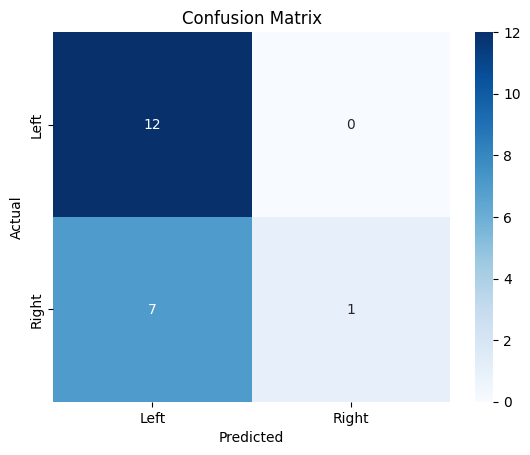

In [10]:
X_train_csp, csp_model = extract_csp_features(X_train, y_train)

X_val_csp = csp_model.transform(X_val)

clf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LDA())
])

clf_pipeline.fit(X_train_csp, y_train)

y_pred = clf_pipeline.predict(X_val_csp)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

sns.heatmap(
    confusion_matrix(y_val, y_pred),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Left', 'Right'],
    yticklabels=['Left', 'Right']
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
